### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba, 2025)

# Cambio 3.0

## Equations of motion of Cambio3.0
The equations of motion of Cambio3.0 are actually the same as Cambio2.0:
$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} \times (1+DC\times T_{anomaly}) [C_{ocean}] \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$

The difference is that ice-albedo is taken into account within each iteration of the Euler loop is that after  we calculate an albedo based on the temperature anomaly, we *use that albedo to calculate a temperature anomaly*.


## Parameterization
The parameterizations we'll be using here are based on a paper by Wunderling et al: https://www.nature.com/articles/s41467-020-18934-3.

## Uploading your climate emissions scenario
As before, you'll need to upload a climate emissions scenario file to the current folder. 

## Learning goals
1. I can describe the geophysical processes behind ice-albedo feedback.
1. I can implement ice-albedo feedback in an Euler loop.

In [2]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc("figure", figsize=(12,8))
import meclib.cl as cl
from copy import copy as makeacopy

### Loading the scheduled flow
In the cell below, load in your scheduled flows file. It'll be most convenient if you use the following naming convention: 

    time, eps, epsdictionary_fromfile = cl.LoadMyScenario(...)


(but of course supplying the name of your own scheduled flows file).

{'dataframe':             time  emissions
0    1750.000000   0.134987
1    1750.667780   0.136492
2    1751.335559   0.138013
3    1752.003339   0.139552
4    1752.671119   0.141107
..           ...        ...
595  2147.328881   4.000000
596  2147.996661   4.000000
597  2148.664441   4.000000
598  2149.332220   4.000000
599  2150.000000   4.000000

[600 rows x 2 columns], 't_0': 2003, 'eps_0': 9, 't_peak': 2040, 't_decarb': 15, 'k': 0.0166}


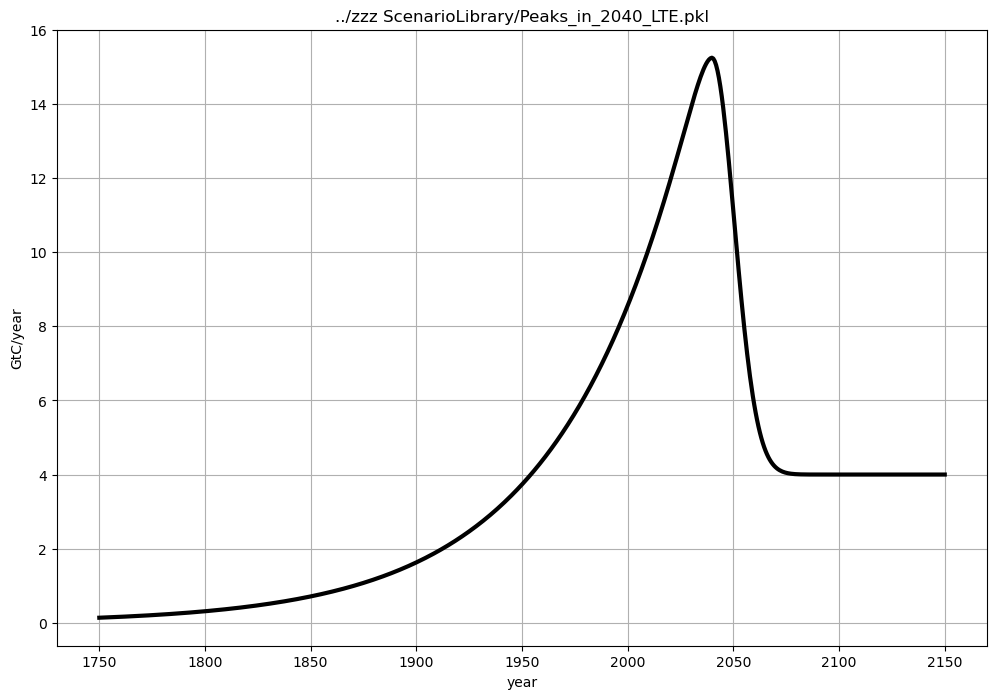

In [4]:
### BEGIN SOLUTION
# Here's loading it in, with graphics
# filename = '../zzz ScenarioLibrary/Peaks_in_2040_default.pkl'
filename = '../zzz ScenarioLibrary/Peaks_in_2040_LTE.pkl'
time, eps, epsdictionary_fromfile = cl.LoadMyScenario(filename,verbose=True)
### END SOLUTION

### Creating a dictionary for climate parameters
In the cell below, we use the CreateClimateParams function to create a dictionary of climate parameters.

In [6]:
ClimateParams = cl.CreateClimateParams(epsdictionary_fromfile)
display(ClimateParams)

{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': 1.43,
 'k_al1_deltaT': 0.471,
 'fractional_k_al1_floor': 0.684,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860834426115428}

### Duplicating Cambio2.0
Below, we reproduce Cambio2.0.

Max of Cambio2 (C_atm) =  1034.5186900803533 at time  2054.5075125208896
Min of Cambio2 (C_atm) =  590.0911464858788 at time  1750.6677796327212
Max of Cambio2 (C_ocean) =  668.9394004083333 at time  2060.517529215381
Min of Cambio2 (C_ocean) =  410.78888417993585 at time  1750.6677796327212


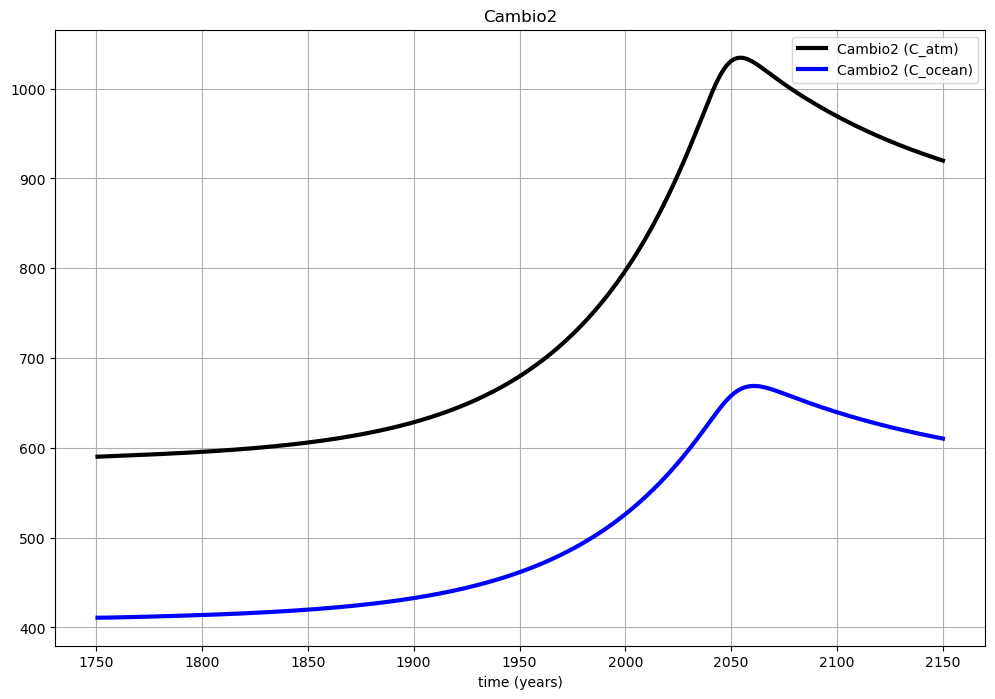

Max of Cambio2 (F_ha) =  15.252233588429393 at time  2039.816360601022
Min of Cambio2 (F_ha) =  0.13649186260348795 at time  1750.6677796327212
Max of Cambio2 (F_ocean_net) =  0.8836271027937528 at time  2077.8797996661333
Min of Cambio2 (F_ocean_net) =  -3.2296460157450326 at time  2039.816360601022
Max of Cambio2 (F_land_net) =  0.0 at time  1750.6677796327212
Min of Cambio2 (F_land_net) =  -7.018716159163475 at time  2055.175292153611


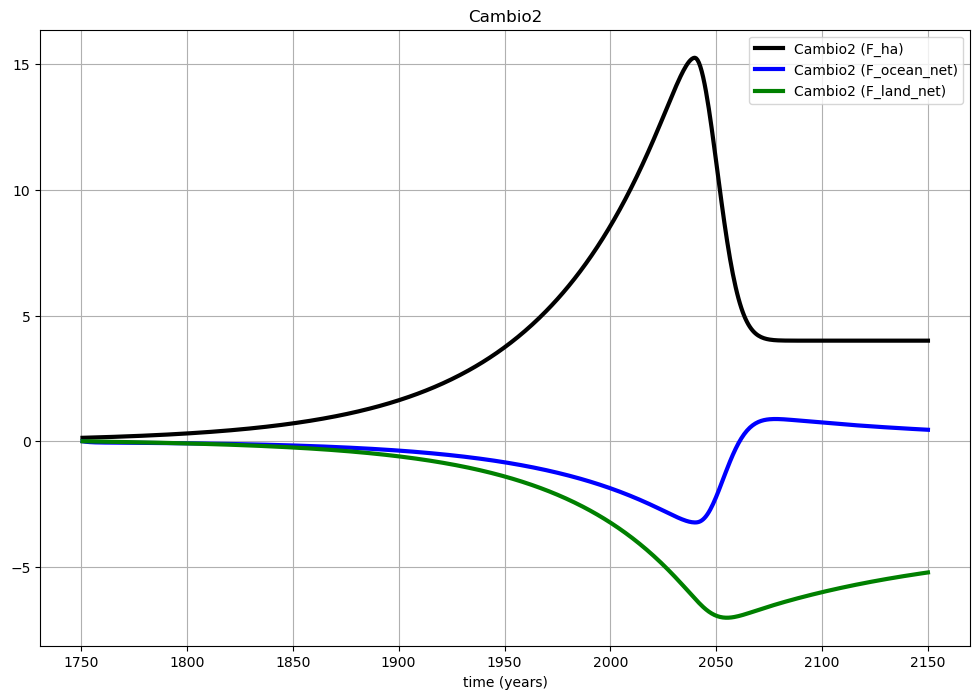

Max of Cambio2 (T_anomaly) =  2.2602645258323046 at time  2055.175292153611
Min of Cambio2 (T_anomaly) =  0.0 at time  1750.6677796327212


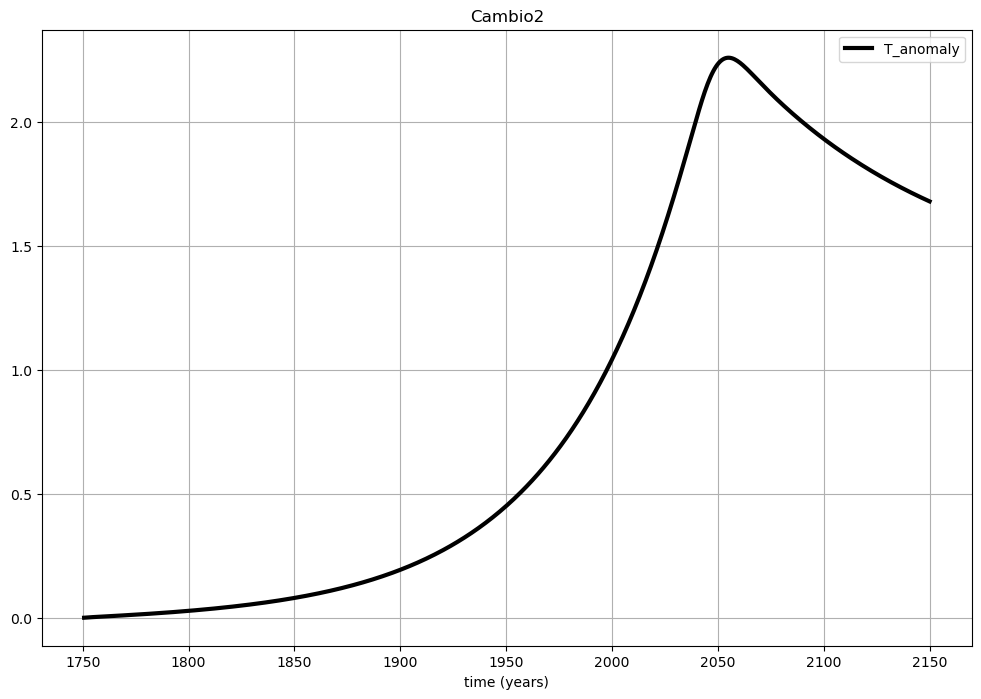

Max of Cambio2 (albedo) =  0.3 at time  1750.6677796327212
Min of Cambio2 (albedo) =  0.3 at time  1750.6677796327212


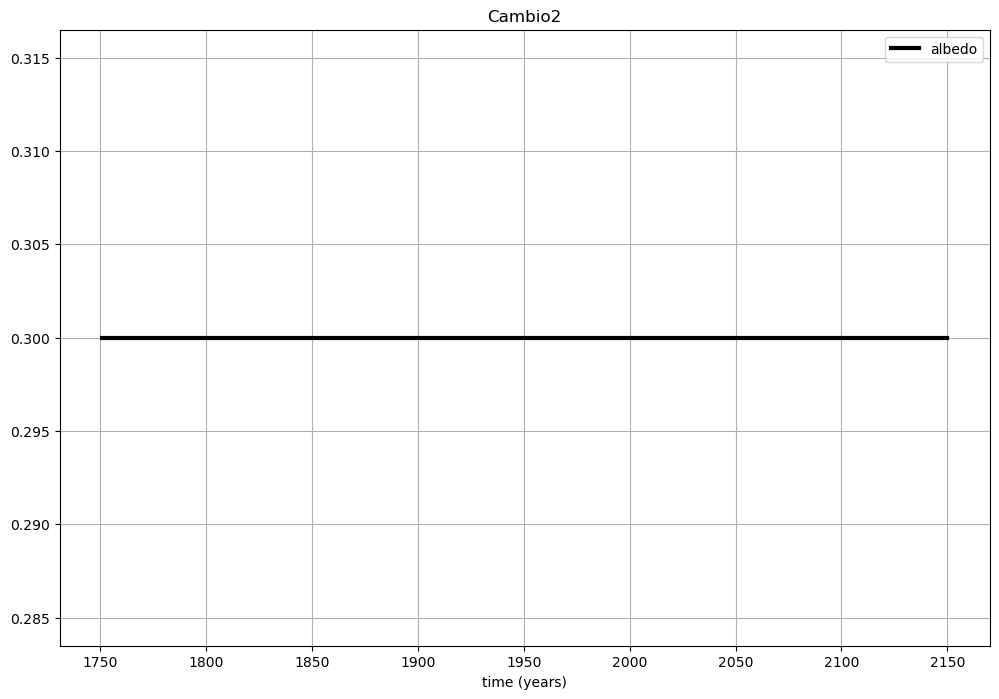

Max of Cambio2 (OceanSurfacepH) =  8.2 at time  1750.6677796327212
Min of Cambio2 (OceanSurfacepH) =  7.956113670409901 at time  2055.175292153611


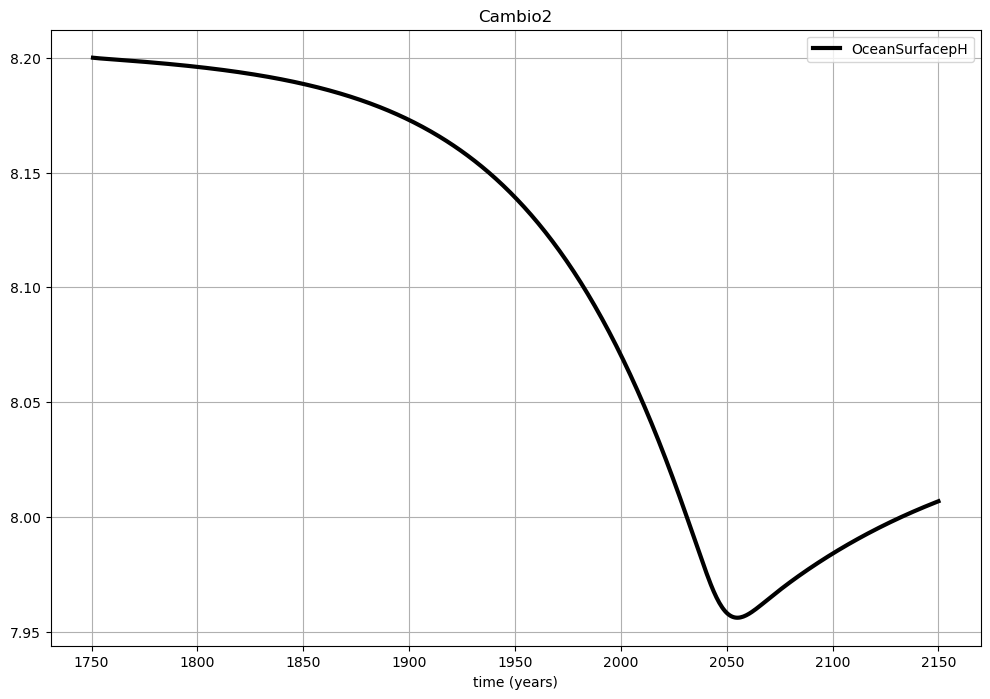

In [8]:
def PropagateCS_Cambio2(previousClimateState, ClimateParams, dt, F_ha):
    """Propagates the state of the climate, with a specified anthropogenic carbon flux"""
    """Returns a new climate state"""

    # Extract constants from ClimateParams
    k_la = ClimateParams['k_la']
    k_al0 = ClimateParams['k_al0']
    k_al1 = ClimateParams['k_al1']
    k_oa = ClimateParams['k_oa']
    k_ao = ClimateParams['k_ao']
    DC = ClimateParams['DC']
    preindustrial_albedo = ClimateParams['preindustrial albedo']
    fractional_albedo_floor = ClimateParams['fractional_albedo_floor']
    albedo_Tstar = ClimateParams['albedo_Tstar']
    albedo_delta_T = ClimateParams['albedo_delta_T']
    k_al1_Tstar = ClimateParams['k_al1_Tstar']
    k_al1_deltaT = ClimateParams['k_al1_deltaT']
    fractional_k_al1_floor = ClimateParams['fractional_k_al1_floor']
    
    # Extract concentrations, albedo, etc, from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']
    albedo = previousClimateState['albedo']
    time = previousClimateState['time']
    
    # Get the temperature implied by the carbon in the atmosphere, and ocean pH
    T_anomaly = cl.Diagnose_T_anomaly(C_atm, preindustrial_albedo, ClimateParams)
    actual_temperature = cl.Diagnose_actual_temperature(T_anomaly)
    OceanSurfacepH = cl.Diagnose_OceanSurfacepH(C_atm,ClimateParams)
    
    # Get new fluxes (including the effect of temperature anomaly on the ocean-to-atmosphere flux)
    F_la = k_la    
    F_al = k_al0 + k_al1*C_atm
    F_oa = k_oa*C_ocean*(1+DC*T_anomaly)    
    F_ao = k_ao*C_atm

    # Get new concentrations of carbon that depend on the fluxes
    C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dt
    C_ocean += (F_ao - F_oa)*dt
    time += dt
    
    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_al'] = F_al
    ClimateState['F_la'] = F_la
    ClimateState['F_ao'] = F_ao
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ha'] = F_ha
    ClimateState['F_ocean_net'] = F_oa-F_ao
    ClimateState['F_land_net'] = F_la-F_al
    ClimateState['time'] = time
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['actual temperature'] = actual_temperature
    ClimateState['OceanSurfacepH'] = OceanSurfacepH
    ClimateState['albedo'] = albedo

    # Return the new climate state
    return ClimateState

# Run Cambio2.0
CS_Cambio2_list = cl.run_Cambio(PropagateCS_Cambio2, ClimateParams, time, eps)

# Choose items to plot
items_to_plot = [['C_atm','C_ocean'],['F_ha','F_ocean_net','F_land_net'],'T_anomaly','albedo','OceanSurfacepH']

# Plot those items
cl.CS_list_plots(CS_Cambio2_list,'Cambio2',items_to_plot)

### Cambio 3.0
Below, the goal is to enhance Cambio2.0 with ice-albedo feedback. It'll be mostly a cut-and-paste job, but you'll need to make an adjustment in the function that propagates the climate state forward. Then make all the plots you did for Cambio2.0.

Max of Cambio3 (C_atm) =  1038.2239308748153 at time  2054.5075125208896
Min of Cambio3 (C_atm) =  590.0911464858788 at time  1750.6677796327212
Max of Cambio3 (C_ocean) =  663.5831393970195 at time  2060.517529215381
Min of Cambio3 (C_ocean) =  410.78888417993585 at time  1750.6677796327212


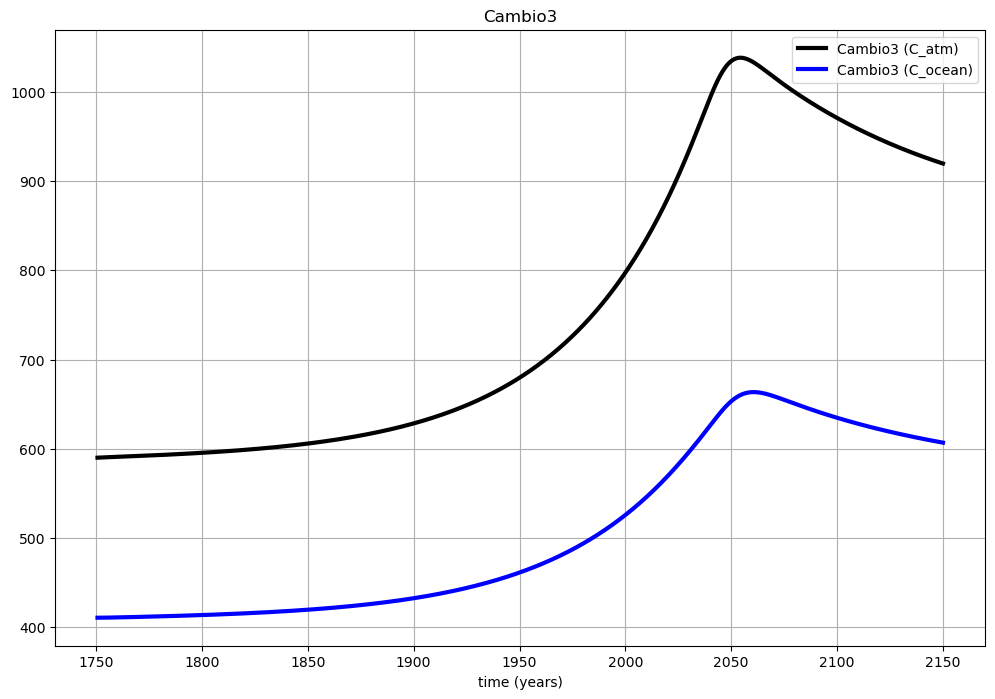

Max of Cambio3 (F_ha) =  15.252233588429393 at time  2039.816360601022
Min of Cambio3 (F_ha) =  0.13649186260348795 at time  1750.6677796327212
Max of Cambio3 (F_ocean_net) =  0.8680876844604626 at time  2077.8797996661333
Min of Cambio3 (F_ocean_net) =  -3.053688680215018 at time  2040.4841402337433
Max of Cambio3 (F_land_net) =  0.0 at time  1750.6677796327212
Min of Cambio3 (F_land_net) =  -7.077219961181299 at time  2055.175292153611


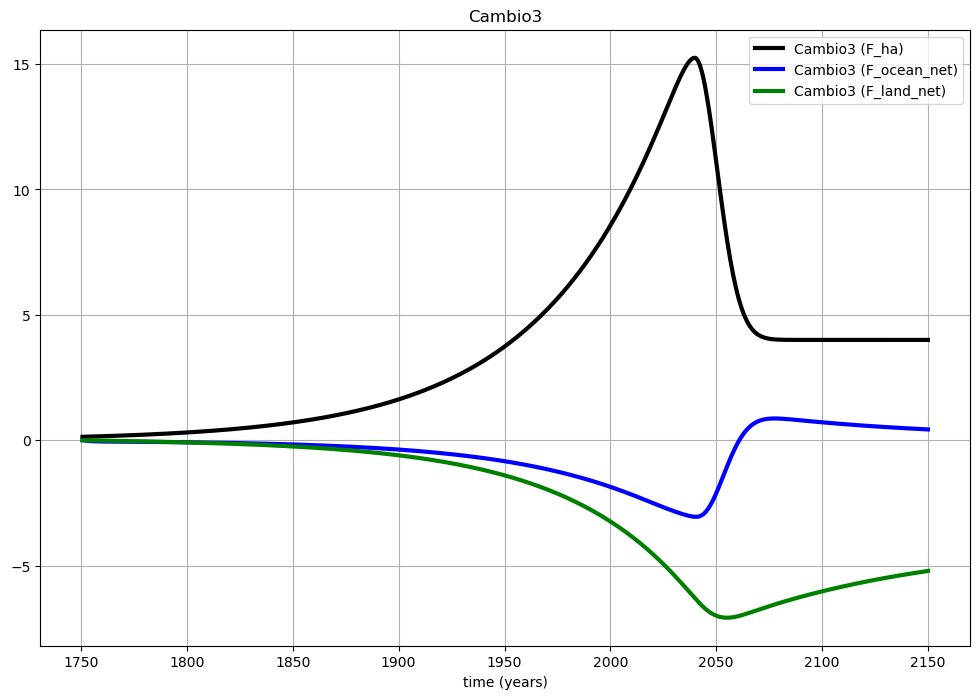

Max of Cambio3 (T_anomaly) =  2.65638173035577 at time  2055.175292153611
Min of Cambio3 (T_anomaly) =  0.0 at time  1750.6677796327212


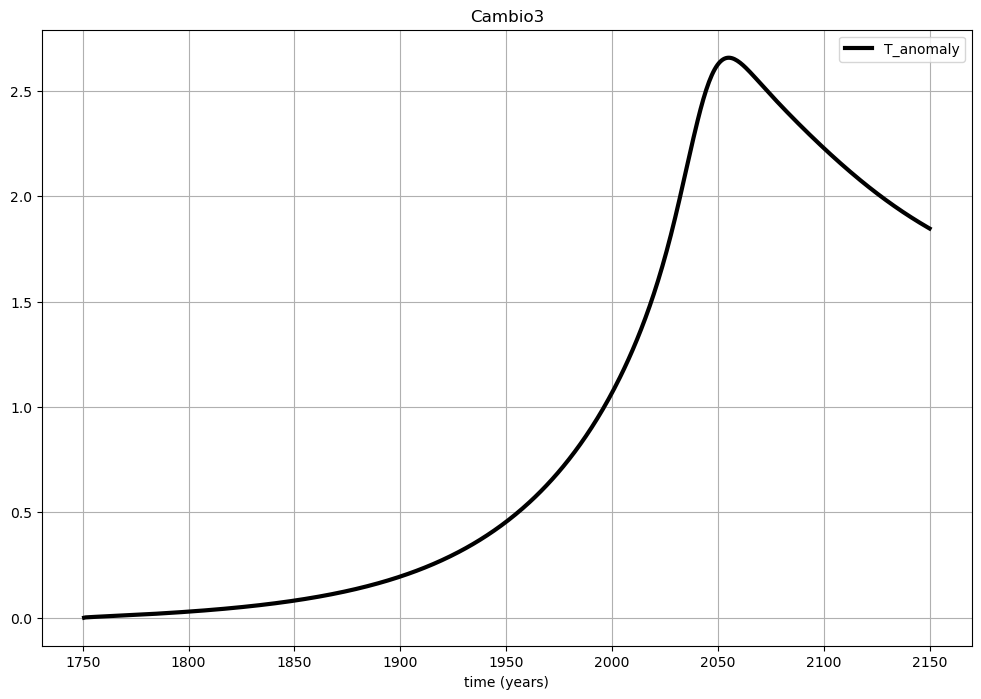

Max of Cambio3 (albedo) =  0.2999896768793822 at time  1750.6677796327212
Min of Cambio3 (albedo) =  0.2963363858215499 at time  2055.175292153611


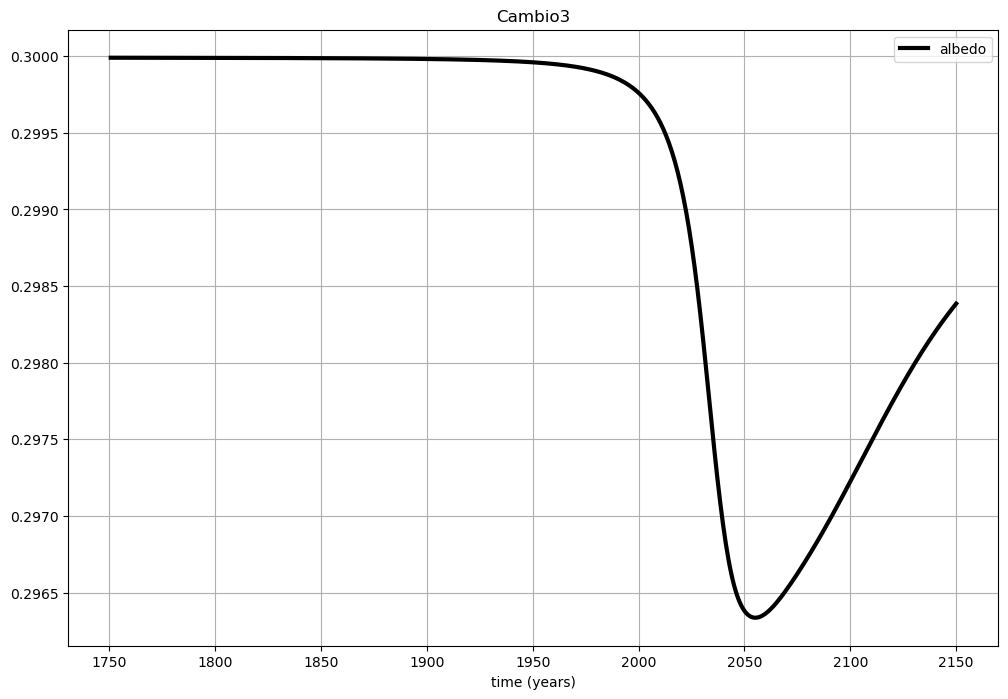

Max of Cambio3 (OceanSurfacepH) =  8.2 at time  1750.6677796327212
Min of Cambio3 (OceanSurfacepH) =  7.95456097657427 at time  2055.175292153611


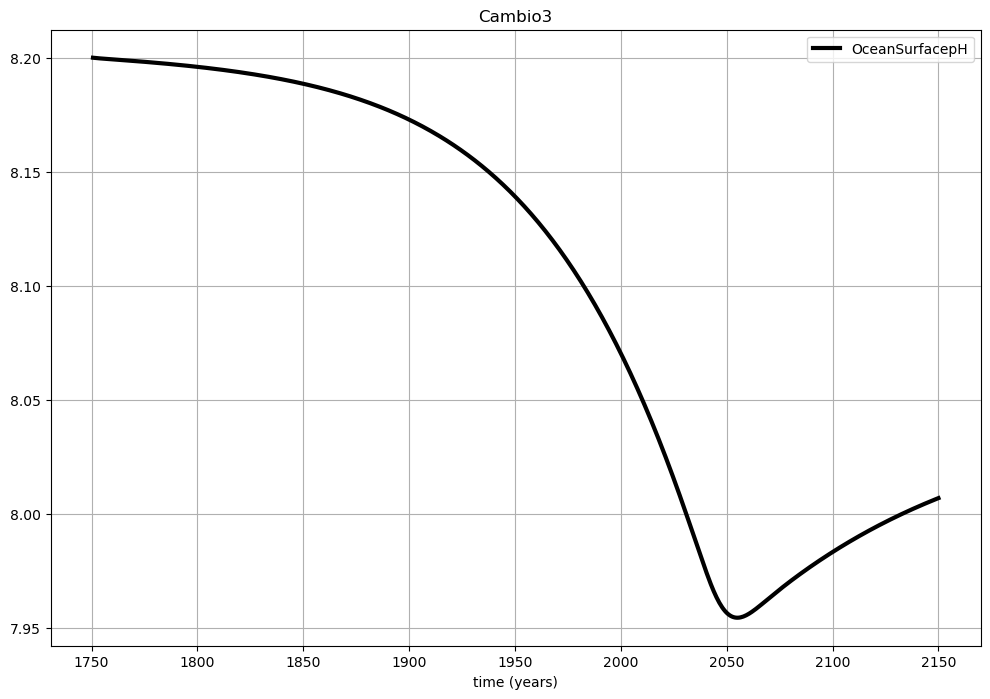

In [10]:
### BEGIN SOLUTION

def PropagateCS_Cambio3(previousClimateState, ClimateParams, dt, F_ha):
    """Propagates the state of the climate, with a specified anthropogenic carbon flux"""
    """Returns a new climate state"""

    # Extract constants from ClimateParams
    k_la = ClimateParams['k_la']
    k_al0 = ClimateParams['k_al0']
    k_al1 = ClimateParams['k_al1']
    k_oa = ClimateParams['k_oa']
    k_ao = ClimateParams['k_ao']
    DC = ClimateParams['DC']
    preindustrial_albedo = ClimateParams['preindustrial albedo']
    fractional_albedo_floor = ClimateParams['fractional_albedo_floor']
    albedo_Tstar = ClimateParams['albedo_Tstar']
    albedo_delta_T = ClimateParams['albedo_delta_T']
    k_al1_Tstar = ClimateParams['k_al1_Tstar']
    k_al1_deltaT = ClimateParams['k_al1_deltaT']
    fractional_k_al1_floor = ClimateParams['fractional_k_al1_floor']
    
    # Extract concentrations, albedo, etc, from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']
    albedo = previousClimateState['albedo']
    time = previousClimateState['time']
    
    # Get the temperature implied by the carbon in the atmosphere and the updated albedo, and ocean pH
    T_anomaly = cl.Diagnose_T_anomaly(C_atm, albedo, ClimateParams)
    actual_temperature = cl.Diagnose_actual_temperature(T_anomaly)
    OceanSurfacepH = cl.Diagnose_OceanSurfacepH(C_atm,ClimateParams)
    
    # Get the albedo implied by the temperature anomaly 
    albedo = cl.Diagnose_albedo(T_anomaly, ClimateParams)

    # Get new fluxes (including the effect of temperature anomaly on the ocean-to-atmosphere flux)
    F_la = k_la    
    F_al = k_al0 + k_al1*C_atm
    F_oa = k_oa*C_ocean*(1+DC*T_anomaly)    
    F_ao = k_ao*C_atm

    # Get new concentrations of carbon that depend on the fluxes
    C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dt
    C_ocean += (F_ao - F_oa)*dt
    time += dt
    
    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_al'] = F_al
    ClimateState['F_la'] = F_la
    ClimateState['F_ao'] = F_ao
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ha'] = F_ha
    ClimateState['F_ocean_net'] = F_oa-F_ao
    ClimateState['F_land_net'] = F_la-F_al
    ClimateState['time'] = time
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['actual temperature'] = actual_temperature
    ClimateState['OceanSurfacepH'] = OceanSurfacepH
    ClimateState['albedo'] = albedo

    # Return the new climate state
    return ClimateState

# Run Cambio3.0
CS_Cambio3_list = cl.run_Cambio(PropagateCS_Cambio3, ClimateParams, time, eps)

# Choose items to plot
items_to_plot = [['C_atm','C_ocean'],['F_ha','F_ocean_net','F_land_net'],'T_anomaly','albedo','OceanSurfacepH']

# Plot those items
cl.CS_list_plots(CS_Cambio3_list,'Cambio3',items_to_plot)
### END SOLUTION

### Pause for analysis
Can you explain why there's such a big difference in the peak temperature between Cambio2.0 and Cambio3.0?

### BEGIN SOLUTION

In Cambio3.0 has albedo feedback.

### END SOLUTION

### Validating and finishing up
Assuming all this has gone smoothly, don't forget to do a Kernel/Restart & Run All, run the whole notebook, and make sure there aren't any errors.